In [3]:
DATA_DIR_BASE = "data"


import math

from IPython.display import display, Markdown
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy.ndimage
import skimage.feature
import skimage.io
import skimage.transform

import fns

run_names, bg_paths, fg_pathses, gt_data = fns.load_all(
    data_dir_base=DATA_DIR_BASE)

In [4]:
import importlib

import preprocessing


importlib.reload(preprocessing)

<module 'preprocessing' from '/Users/jenny.vophamhi/Desktop/CZB/others/from_greg/2021-07-15 sw counts vs gt vis 20210913/preprocessing.py'>

# Data dir summary

In [5]:
num_fg_paths = 0
num_fg_matched = 0
all_fg_paths = {} # List of FG image paths per run name
for run_name in run_names:
    all_fg_paths[run_name] = [
       x for lane_no in fg_pathses[run_name]
       for x in fg_pathses[run_name][lane_no]]
    num_fg_paths += len(all_fg_paths[run_name])

for run_name in run_names:
    print(f"Run {run_name}:")
    print(f"  BG Lanes:        {','.join(str(x) for x in bg_paths[run_name])}")
    print(f"  Num FG images:   {len(all_fg_paths[run_name])}")
    n_matched = sum(len(x) for x in gt_data[run_name].values()) \
                if run_name in gt_data else 0
    num_fg_matched += n_matched
    print(f"  Num matched GTs: {n_matched}")

unm_gt_ids = ()
if None in gt_data:
    print()
    print("Unmatched GTs:")
    unm_gt_ids = [
        f"  {ts}-{lane_no}"
        for lane_no in gt_data[None]
        for ts in gt_data[None][lane_no]]
    print("\n".join(unm_gt_ids))

print()
print(f"Total FG images:        {num_fg_paths}")
print(f"Total GT files:         {num_fg_matched + len(unm_gt_ids)}")
print(f"Total matched GT files: {num_fg_matched}")

Run 20201217:
  BG Lanes:        5,4,6,7,3,2,0,1
  Num FG images:   8
  Num matched GTs: 4
Run 20201216:
  BG Lanes:        5,4,6,7,3,2,0,1
  Num FG images:   40
  Num matched GTs: 10
Run 20200901:
  BG Lanes:        0,1,3,2,6,7,5,4
  Num FG images:   32
  Num matched GTs: 16
Run 20200916b:
  BG Lanes:        6,7,5,4,0,1,3,2
  Num FG images:   24
  Num matched GTs: 5
Run 20200916a:
  BG Lanes:        5,4,6,7,3,2,0,1
  Num FG images:   16
  Num matched GTs: 5

Unmatched GTs:
  20201002-150536-6
  20201002-132522-6
  20201002-135404-6
  20201002-142245-6
  20201002-140824-4
  20201002-150536-4
  20201002-131101-4
  20201002-132522-4
  20201002-135404-4
  20201002-133942-4
  20201002-145125-4
  20201002-125630-4
  20201002-142245-4
  20201002-131101-2
  20201002-132522-2
  20201002-140824-2
  20201002-135404-2
  20201002-133942-2
  20201002-142245-2
  20201002-125630-2
  20201002-132522-3
  20201002-131101-3
  20201002-135404-3
  20201002-145125-3
  20201002-133942-3
  20201002-142245-3
 

# GT visualization

In [6]:
DOWNSAMPLE_FACTOR = 2
KERNEL_SIZE = 150
DISC_RADIUS = 3

pp_params = {
    "input_rescale_factor":   None,
    "input_gaussian_sigma":   None,
    "align_bg_pixel_thresh":  0.25,
    "align_bg_row_thresh":    0.35,
    "align_mask_margin":      0.01,
    "align_cutout_height":    0.75,
    "align_oversub_factor":   1.05,
    "cleanup_wall_margin":    0.05,
    "cleanup_bg_brt_thresh":  0.25,
    "cleanup_bg_grow_factor": 1.0e-2,
    "cleanup_fg_brt_thresh":  0.05,
    "cleanup_fg_grow_factor": 1.0e-2,
    "cleanup_fg_grow_cycles": 4,
    "cleanup_fg_size_thresh": 3.0e-4,
    "cleanup_gaussian_sigma": None,
}


def crop_image(img):
    ycrop = int((2048-948)/2)
    xcrop = int((2448-1948)/2)
    return img[ycrop:-1*ycrop,xcrop:-1*xcrop]

def cross_correlate(img, kernel):
    cc_img = skimage.feature.match_template(img, kernel, pad_input=True)
    cc_img[cc_img < 0.] = 0.
    return cc_img

def get_kernel():
    kernel = np.zeros((KERNEL_SIZE, KERNEL_SIZE), 'uint16')
    kernelCtr = KERNEL_SIZE / 2
    for rr in range(0, KERNEL_SIZE + 1):
        for cc in range(0, KERNEL_SIZE + 1):
            if  math.sqrt((rr - kernelCtr)**2 + (cc - kernelCtr)**2) < DISC_RADIUS:
                kernel[rr, cc] = 65535
    return skimage.transform.downscale_local_mean(
        kernel, (DOWNSAMPLE_FACTOR,DOWNSAMPLE_FACTOR))

def find_blobs(cc_img):
    return skimage.feature.blob_dog(
        cc_img, min_sigma=5, max_sigma=15, threshold=0.08, overlap=0.8)

In [7]:
run_names

['20201217', '20201216', '20200901', '20200916b', '20200916a']

In [8]:
run_name = '20201217'
gt_data[run_name].keys()

dict_keys([5, 4, 0, 2])

## Run: `20201217`

### Lane 2

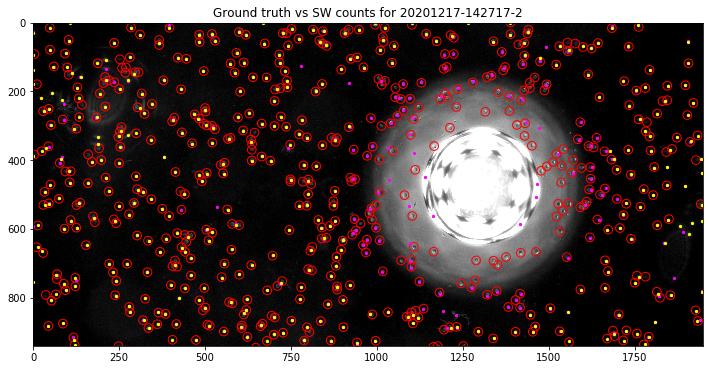

gt_xs:	 568
xs:	 457
pp_xs:	 394


In [11]:
kernel = get_kernel()

gt_xs_list, xs_list, pp_xs_list = [], [], []
run_name_list, lane_no_list, ts_list = [], [], []

#for run_name in run_names:
for run_name in ['20201217']:
    if run_name not in gt_data:
        continue
    display(Markdown(f'## Run: `{run_name}`'))
#     for lane_no in sorted(gt_data[run_name].keys()):
    for lane_no in [2]:
        pp = preprocessing.Cci1ImagePreprocessing(**pp_params)
        pp.set_bg_image_from_path(bg_paths[run_name][lane_no])
        display(Markdown(f'### Lane {lane_no}'))
        for ts in sorted(gt_data[run_name][lane_no].keys()):
            plt.figure(figsize=(12.,12.))

            pp_img, valid_area, info = pp.process_fg_image_from_path(
                fg_pathses[run_name][lane_no][ts])

            pp_cc_img = cross_correlate(crop_image(pp_img), kernel)
            pp_ys, pp_xs, pp_sigmas = zip(*(find_blobs(pp_cc_img)))

            cc_img = cross_correlate(crop_image(info["fg_image"]), kernel)
            ys, xs, sigmas = zip(*(find_blobs(cc_img)))
            ys += info["shift"][0]
            xs += info["shift"][1]

            gt_ys, gt_xs = zip(*gt_data[run_name][lane_no][ts])
            gt_ys += info["shift"][0]
            gt_xs += info["shift"][1]

            # Shift image and compress dynamic range for display
            disp_img = scipy.ndimage.shift(
                crop_image(info["fg_image"]) ** 0.5, info["shift"])
            plt.imshow(disp_img, cmap=plt.cm.gray, vmin=0.3, vmax=1.)
            plt.scatter(gt_xs, gt_ys, s=75., facecolors='none', edgecolors='red')
            plt.scatter(xs, ys, s=5., facecolors='magenta')
            plt.scatter(pp_xs, pp_ys, s=5., facecolors='yellow')
                        
            plt.title(f"Ground truth vs SW counts for {ts}-{lane_no}")
            plt.xlim(0, 1948)
            plt.ylim(940, 0)
            plt.show()
            
            gt_xs_list.append(len(gt_xs))
            xs_list.append(len(xs))
            pp_xs_list.append(len(pp_xs))
            run_name_list.append(run_name)
            lane_no_list.append(lane_no)
            ts_list.append(ts)
            
            print('gt_xs:\t', len(gt_xs))
            print('xs:\t', len(xs))
            print('pp_xs:\t', len(pp_xs))


In [13]:
info['shift']

(-1.0, 0.0)

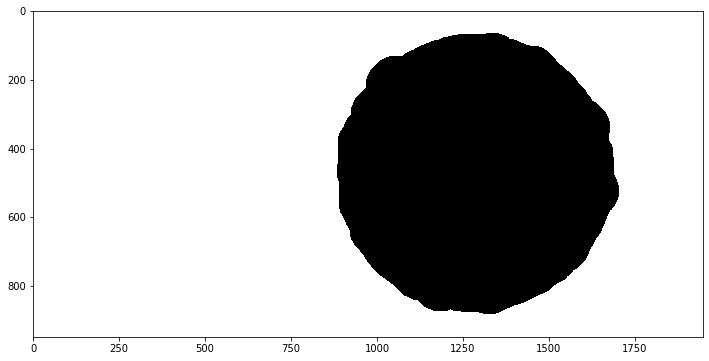

In [44]:
plt.figure(figsize=(12.,12.))
disp_mask = scipy.ndimage.shift(crop_image(info["fg_feature_mask"]) ** 0.5, info["shift"])
plt.imshow(disp_mask, cmap=plt.cm.gray, vmin=0.3, vmax=1.)
plt.show()

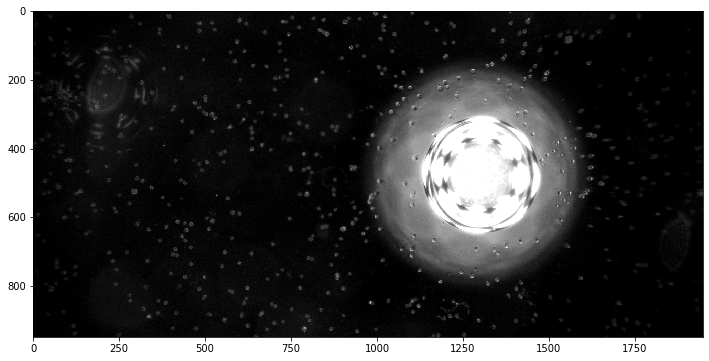

In [45]:
plt.figure(figsize=(12.,12.))
disp_img = scipy.ndimage.shift(crop_image(info["fg_image"]) ** 0.5, info["shift"])
plt.imshow(disp_img, cmap=plt.cm.gray, vmin=0.3, vmax=1.)
plt.show()

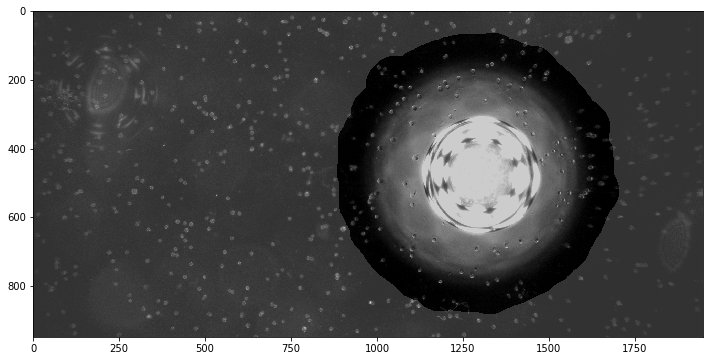

In [46]:
plt.figure(figsize=(12.,12.))
plt.imshow(disp_img, cmap=plt.cm.gray, vmin=0.3, vmax=1.)
plt.imshow(disp_mask, cmap='gray', alpha=0.2)
plt.show()

In [54]:
valid_area = disp_mask.sum()
total_area = disp_mask.shape[0] * disp_mask.shape[1]

In [55]:
valid_area/total_area

0.7174468675001516